Dans ce script, nous allons tester différents modèles de type convolution Nelle pour examiner leur performance. Nous allons ensuite tester s'ils sont robustes lorsqu'on applique une rotation à l'image d'entrée.

# displaying sample images

In [1]:
import retinoto_py as fovea
N_show = 6
args = fovea.Params(batch_size=N_show, do_mask=False, verbose=True)
args

verbose True
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O - Timestamp (UTC)  2025-12-05_10-30-02  user laurent >  pytorch==2.9.1
> device (Apple Silicon/MacOS) - macos_version = 26.1
Random seed 2018 has been set.


Params(image_size=224, do_mask=False, do_fovea=False, rs_min=0.0, rs_max=-6.0, padding_mode='zeros', seed=2018, batch_size=6, num_workers=1, in_memory=False, model_name='convnext_base', num_epochs=24, subset_factor=1, lr=1e-06, delta1=0.1, delta2=0.007, weight_decay=0.03, label_smoothing=0.2, shuffle=True, verbose=True)

In [2]:
VAL_DATA_DIR = args.DATAROOT / 'Imagenet_full' / 'val'
# VAL_DATA_DIR = args.DATAROOT / 'Imagenet_bbox' / 'val'
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR)
val_loader = fovea.get_loader(args, val_dataset)

In [3]:
print(VAL_DATA_DIR)

/Users/laurent/data/Imagenet/Imagenet_full/val


In [4]:
images, labels = next(iter(val_loader))
images, labels = images.to('cpu'), labels.to('cpu')

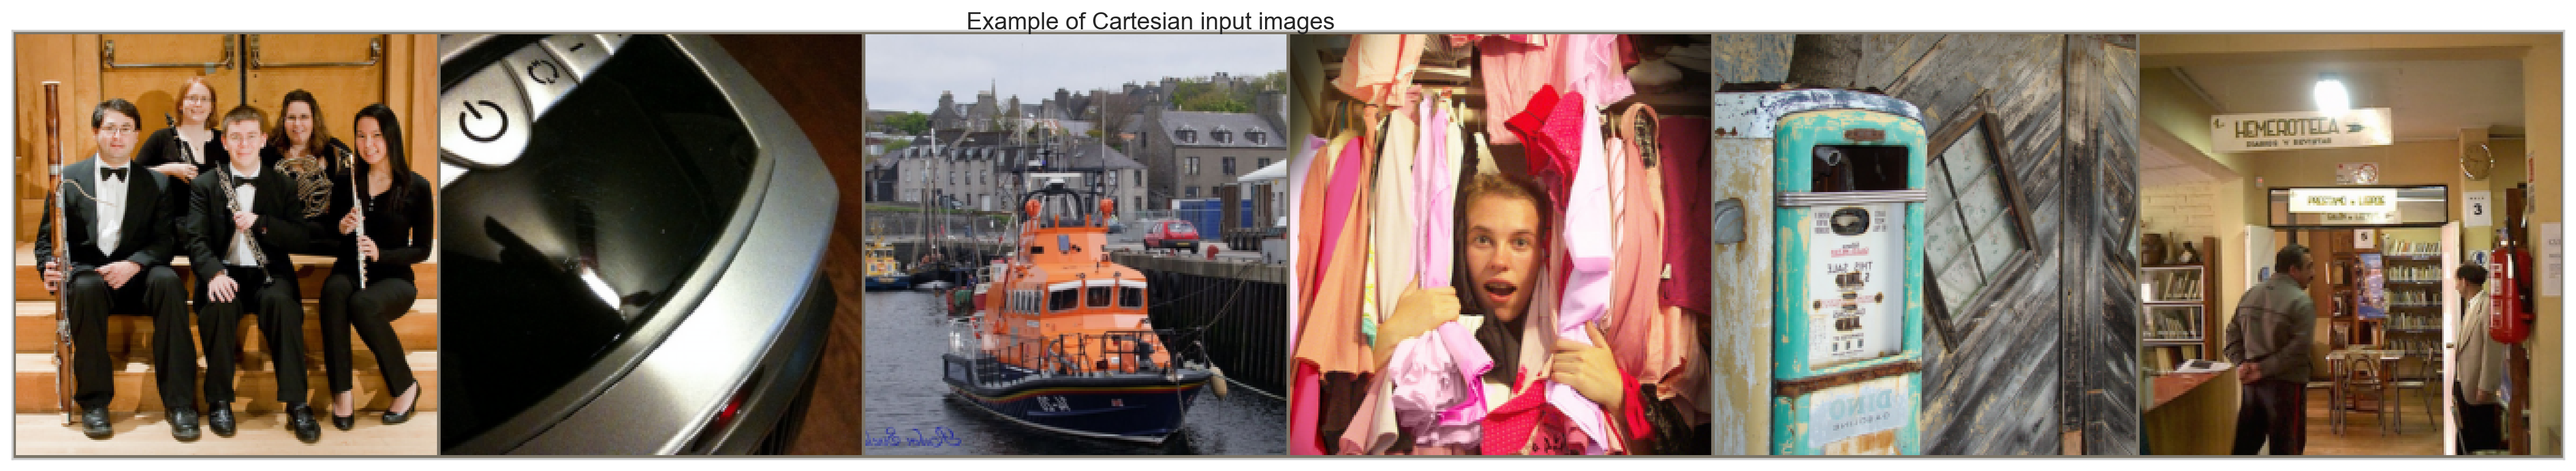

In [5]:
fig, ax = fovea.imshow(images, title='Example of Cartesian input images', fig_height=5)
fovea.plt.show()


# displaying sample images with a mask

verbose False


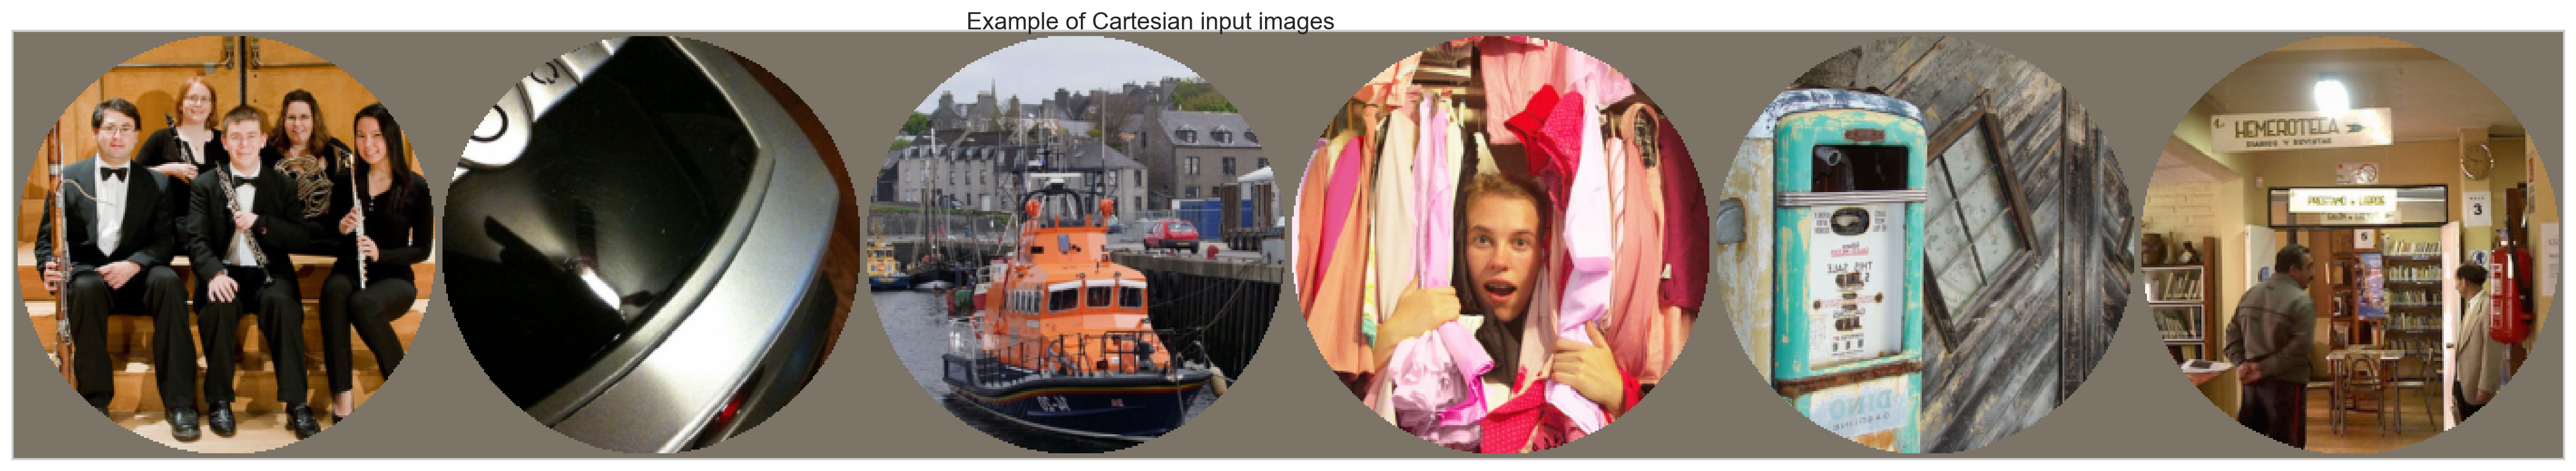

In [6]:
args = fovea.Params(batch_size=N_show, do_mask=True)
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR)
val_loader = fovea.get_loader(args, val_dataset)
images, labels = next(iter(val_loader))
images, labels = images.to('cpu'), labels.to('cpu')
fig, ax = fovea.imshow(images, title='Example of Cartesian input images', fig_height=5)
fovea.plt.show()


# displaying sample images with a mask and a rotation

verbose False


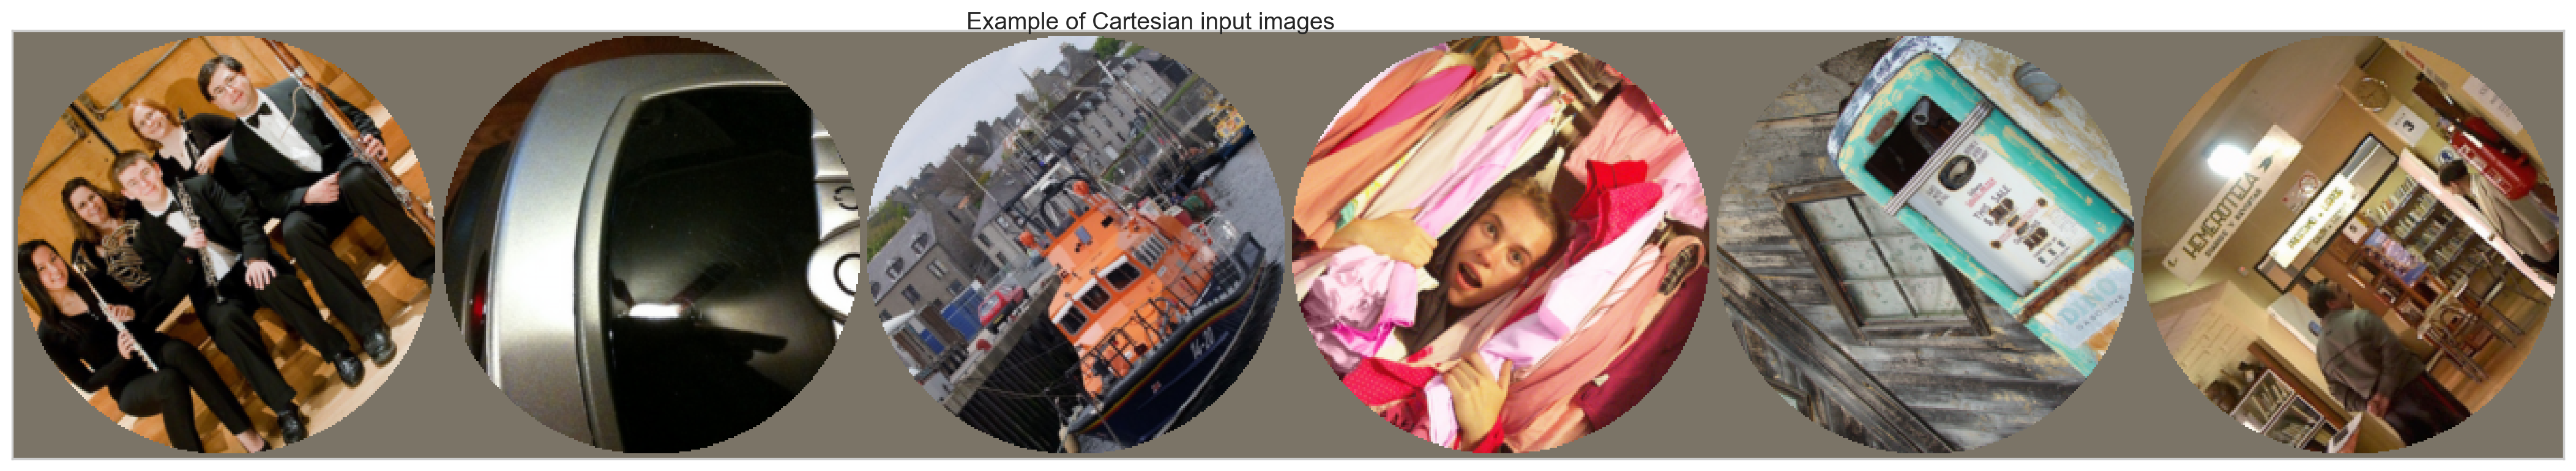

In [7]:
args = fovea.Params(batch_size=N_show, do_mask=True)
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, angle_min=40, angle_max=50)
val_loader = fovea.get_loader(args, val_dataset)
images, labels = next(iter(val_loader))
images, labels = images.to('cpu'), labels.to('cpu')
fig, ax = fovea.imshow(images, title='Example of Cartesian input images', fig_height=5)
fovea.plt.show()


# testing one image at different rotations

In [8]:
seed = 1998
args = fovea.Params(batch_size=1, do_mask=True, shuffle=True, seed=seed, verbose=False)
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR)
val_loader = fovea.get_loader(args, val_dataset)
model = fovea.load_model(args)
model.eval()

for _ in range(87):
    images, true_labels = next(iter(val_loader))
    images = images.to(args.device)
    true_labels = true_labels.to(args.device)
images.shape, true_labels


verbose False


(torch.Size([1, 3, 224, 224]), tensor([692], device='mps:0'))

In [9]:
all_angles = fovea.np.linspace(0, 360, 22) 


In [10]:
all_image_tensors = []
mask = fovea.make_mask(args.image_size).to(args.device)
for _, angle in enumerate(all_angles):
    if _==0: 
        all_image_tensors.append(images * mask)
    else:
        all_image_tensors.append(images[:, 0, 0] * fovea.torch.ones_like(images))
all_images = fovea.torch.cat(all_image_tensors, dim=0)
all_images.shape

torch.Size([22, 3, 224, 224])

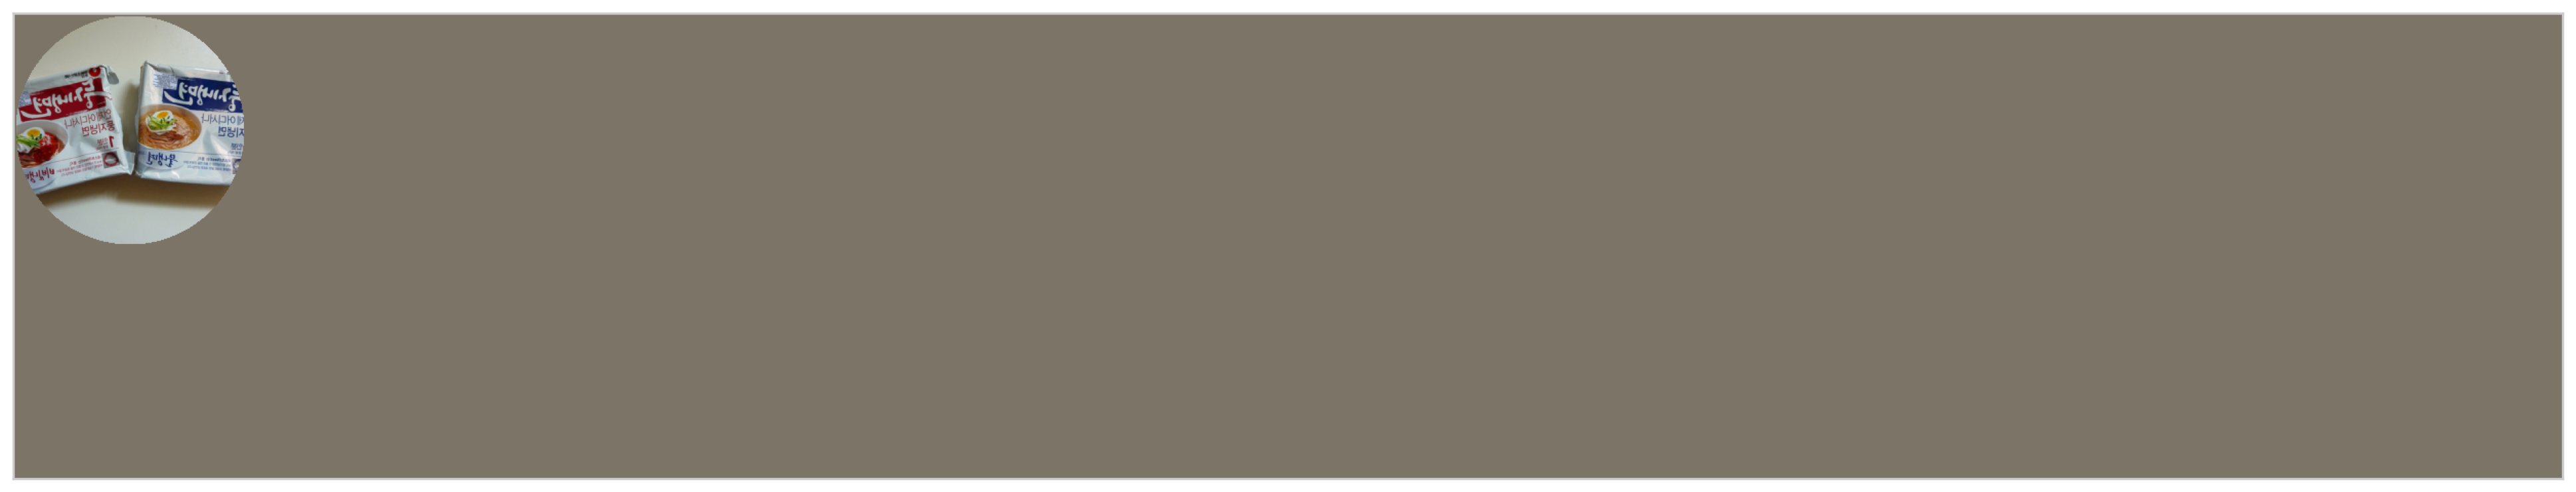

In [11]:
fig, ax = fovea.imshow(all_images.cpu(), fig_height=5)
fovea.savefig(fig, name='16_rotation_attack_sample_rotations_zero', figures_folder=args.figures_folder, exts=['png'])

In [12]:
all_image_tensors = []
all_label_tensors = []

from torchvision.transforms import InterpolationMode

for angle in all_angles:
    image_rot = fovea.TF.rotate(images, angle, interpolation=InterpolationMode.BILINEAR) * mask
    
    # Append the batch of rotated images and their corresponding labels
    all_image_tensors.append(image_rot)
    all_label_tensors.append(true_labels) # Append the full label tensor

# --- AFTER THE LOOP: Concatenate everything at once ---
# This is the efficient way!
all_images = fovea.torch.cat(all_image_tensors, dim=0)
all_labels = fovea.torch.cat(all_label_tensors, dim=0)

all_images.shape, all_labels.shape

(torch.Size([22, 3, 224, 224]), torch.Size([22]))

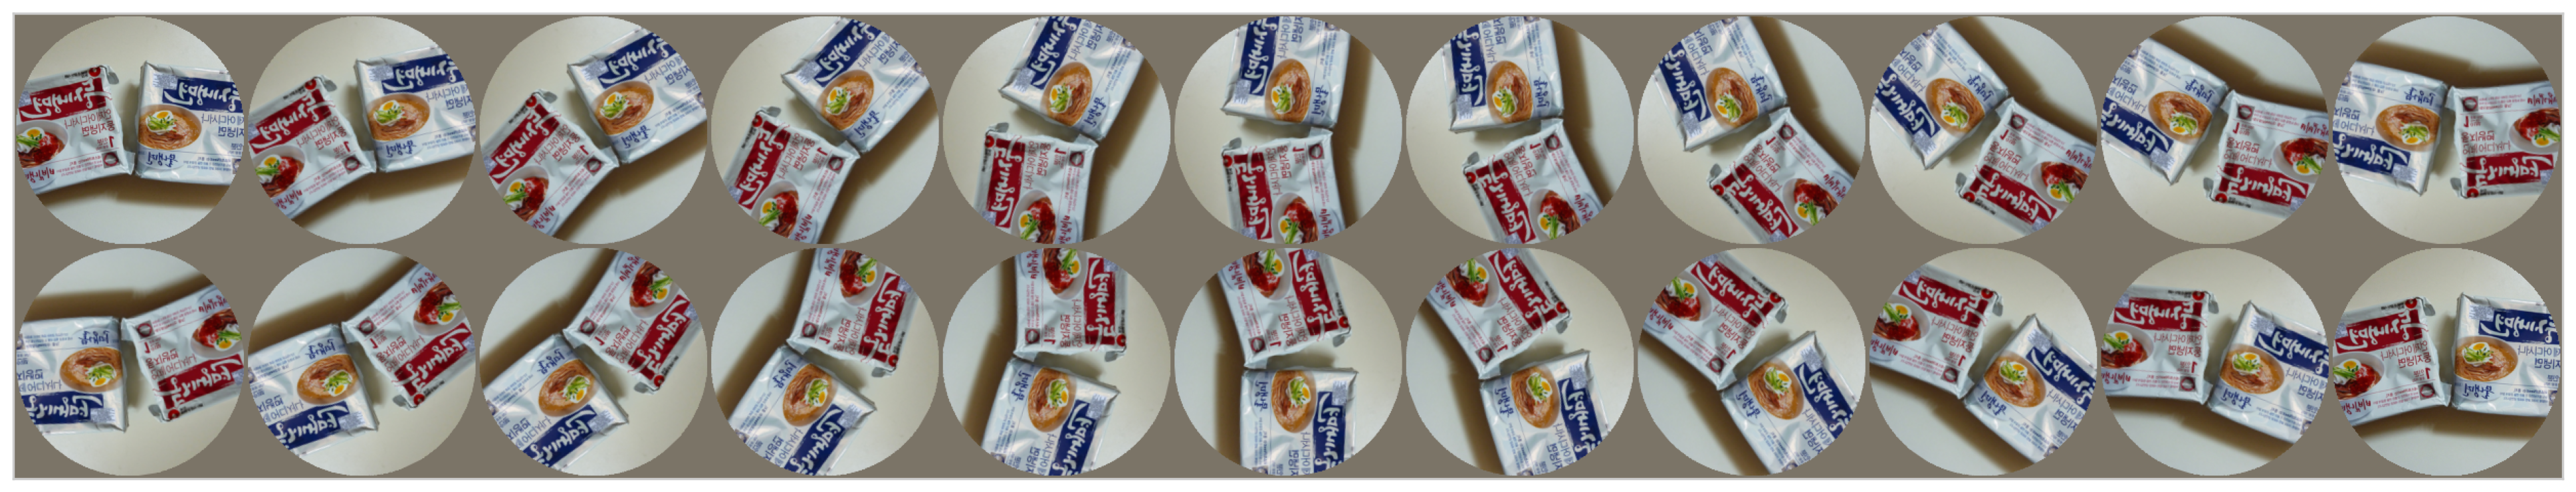

In [13]:
fig, ax = fovea.imshow(all_images.cpu(), fig_height=5)
fovea.savefig(fig, name='16_rotation_attack_sample_rotations', figures_folder=args.figures_folder, exts=['png'])

In [14]:
criterion = fovea.torch.nn.CrossEntropyLoss(reduction='none')
with fovea.torch.no_grad():
    outputs = model(all_images)
    loss = criterion(outputs, all_labels).cpu().numpy()
    logits = outputs.cpu().numpy()

    _, predicted_labels = fovea.torch.max(outputs, dim=1)
    correct_predictions_in_batch = (predicted_labels == all_labels)
predicted_labels, all_labels

(tensor([692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692], device='mps:0'),
 tensor([692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692, 692], device='mps:0'))

In [15]:
correct_predictions_in_batch, loss

(tensor([True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True],
        device='mps:0'),
 array([0.48852324, 1.0998617 , 1.1836841 , 0.96018237, 0.77515143,
        0.7974785 , 0.9309055 , 0.8149877 , 0.936994  , 1.2125114 ,
        1.0960244 , 1.1110039 , 1.3343555 , 0.77211577, 0.8766893 ,
        0.87372   , 0.84551966, 0.7465798 , 0.84918416, 1.306047  ,
        0.9465238 , 0.48852324], dtype=float32))

In [16]:
worst_angle = loss.argmax()
worst_angle, predicted_labels[worst_angle]

(np.int64(12), tensor(692, device='mps:0'))

In [17]:
idx_to_label = fovea.get_idx_to_label(args)
idx_to_label[predicted_labels[worst_angle]], idx_to_label[all_labels[worst_angle]]

Loading labels from local cache cached_data/imagenet_class_index.json...


('packet', 'packet')

In [18]:
all_images[[0, worst_angle], ...].shape

torch.Size([2, 3, 224, 224])

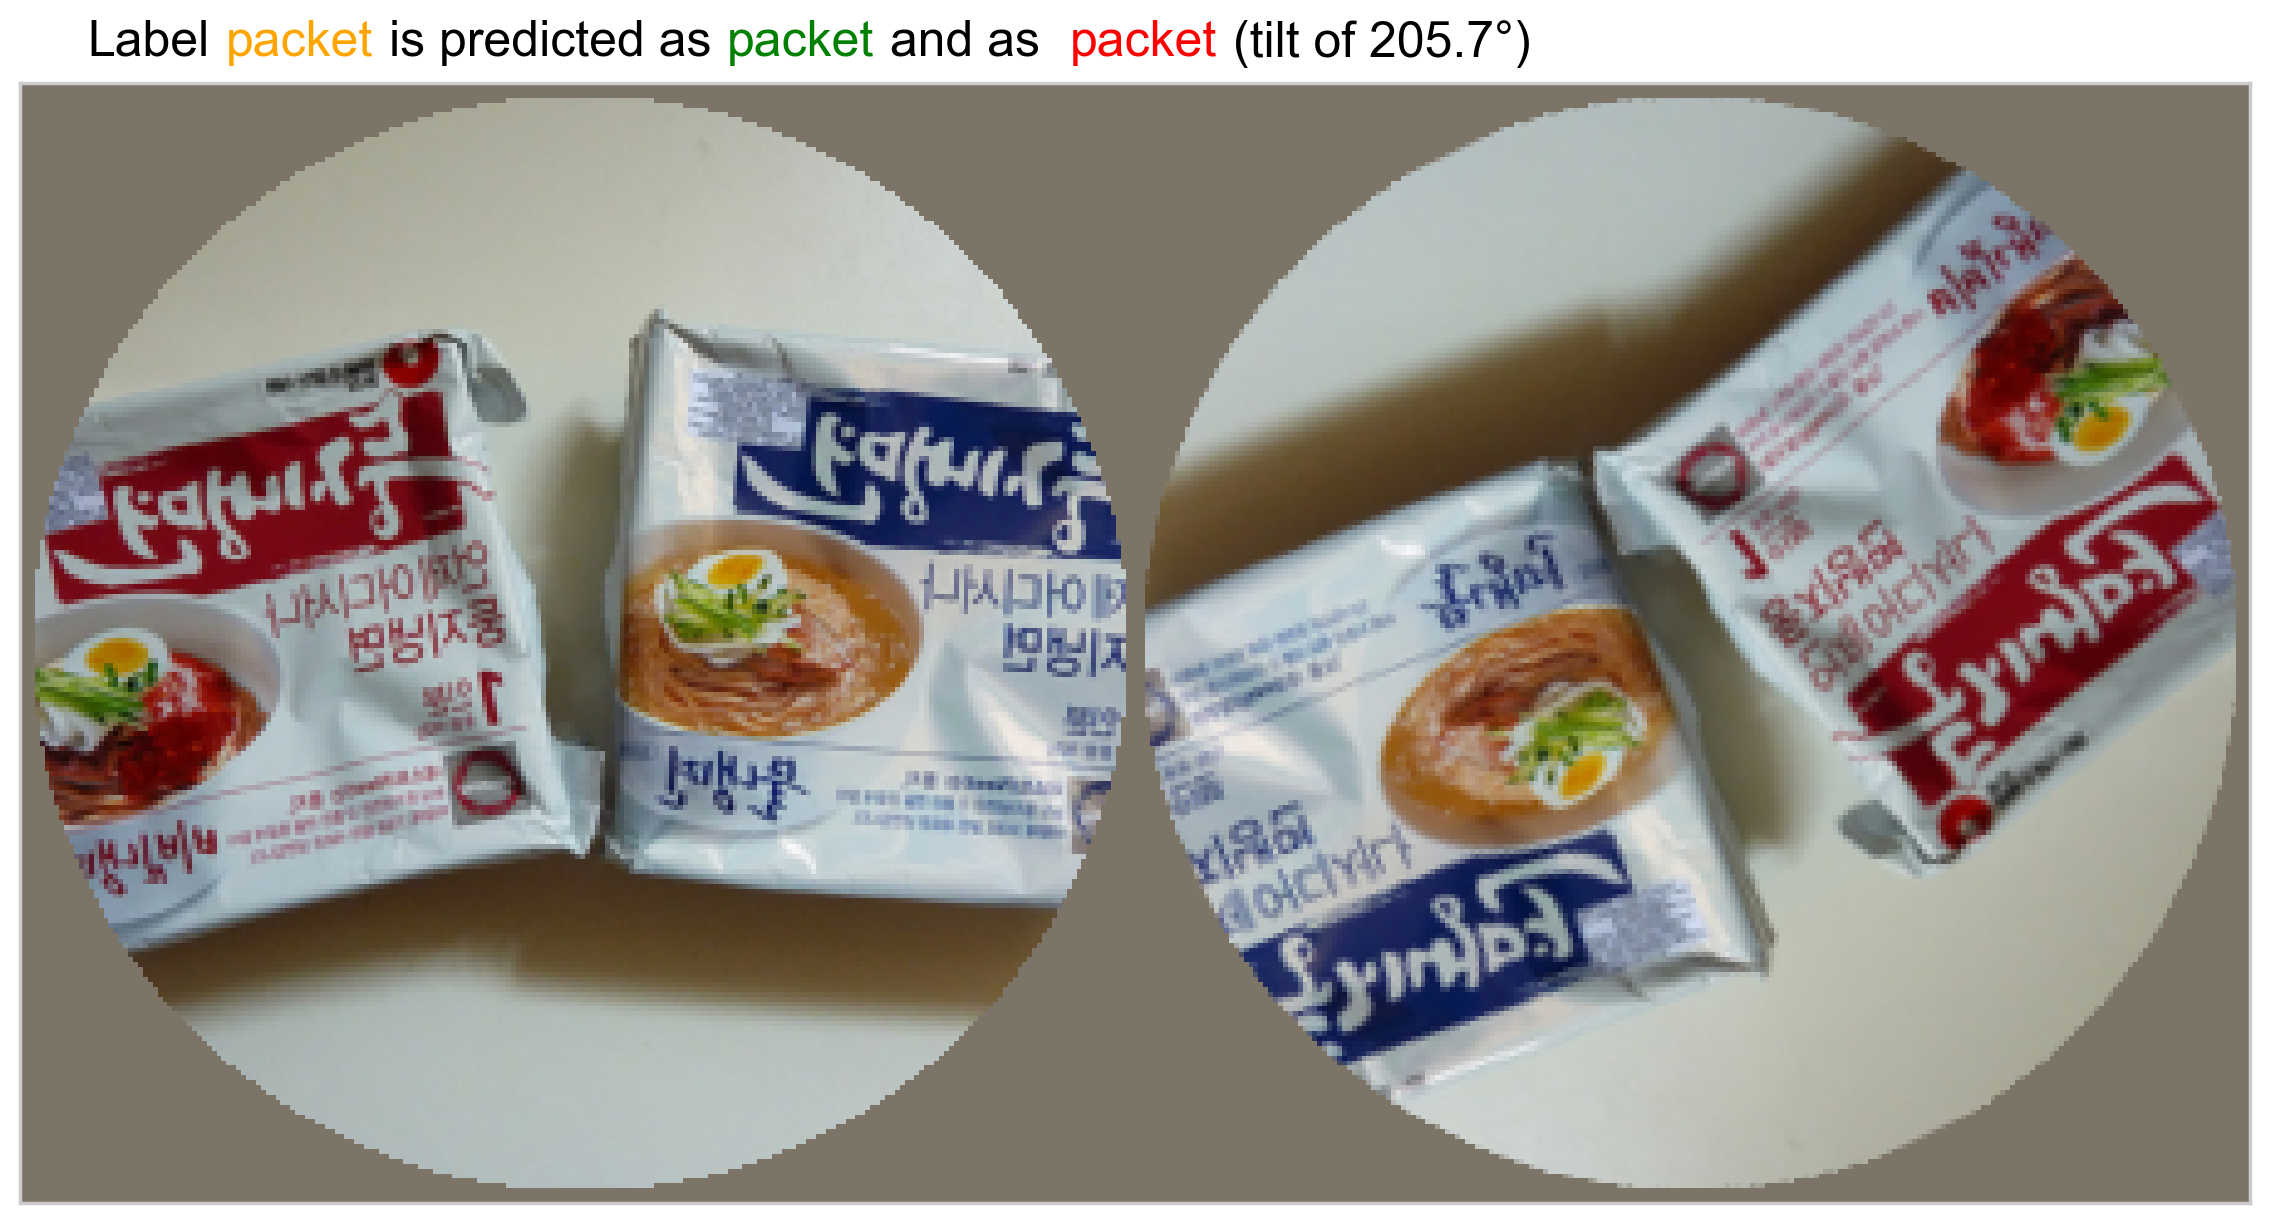

In [19]:
fig_height = 8

def make_title(fig, ax, A, B, C):
    # We position text relative to the FIGURE (0-1), not the axes.
    # This avoids transform complexities.
    transform = fig.transFigure
    
    text_segments = [
        (f"Label", 'black'),
        (f"{A}", 'orange'),
        (f"is predicted as", 'black'),
        (f"{B}", 'green'),
        (f"and as ", 'black'),
        (f"{C}", 'red'),
        (f"(tilt of {all_angles[worst_angle]:.1f}°)", 'black',),
    ]
    
    # Position the title block relative to the figure's width
    x_pos = 0.21 # Start 5% from the left edge of the figure
    y_pos = 0.99  # Start 97% from the bottom of the figure
    font_size = ax.title.get_fontsize() #or plt.rcParams['font.size'] # Get title font size

    for segment, color in text_segments:
        text_obj = fig.text(x_pos, y_pos, segment, color=color, transform=transform, 
                            fontsize=font_size, va='top', ha='left')
        
        # Draw the canvas to ensure the bbox is accurate
        fig.canvas.draw()
        bbox = text_obj.get_window_extent()
        
        # The spacing is now just the width of the text in figure coordinates
        x_pos = (bbox.x1 - fig.bbox.x0) / fig.bbox.width + 0.005 # Add a small space

    return fig, ax


fig, ax = fovea.imshow(all_images[[0, worst_angle], ...].cpu(), title=None, fig_height=fig_height)
fig, ax = make_title(fig, ax, idx_to_label[all_labels[0]], idx_to_label[predicted_labels[0]], idx_to_label[predicted_labels[worst_angle]])
fovea.savefig(fig, name='16_attack', figures_folder=args.figures_folder, exts=['png'])


In [20]:
def one_rotation_attack(image, true_label, all_angles=fovea.np.linspace(0, 360, 22), fig_height = 6):

    all_image_tensors = []
    all_label_tensors = []
    for angle in all_angles:
        image_rot = fovea.TF.rotate(image, angle, interpolation=InterpolationMode.BILINEAR) * mask
        all_image_tensors.append(image_rot)
        all_label_tensors.append(true_label) # Append the full label tensor
    all_images = fovea.torch.cat(all_image_tensors, dim=0)
    all_labels = fovea.torch.cat(all_label_tensors, dim=0)

    with fovea.torch.no_grad():
        outputs = model(all_images)
        loss = criterion(outputs, all_labels).cpu().numpy()
        _, predicted_labels = fovea.torch.max(outputs, dim=1)

    worst_angle = loss.argmax()
    
    fig, ax = fovea.imshow(all_images[[0, worst_angle], ...].cpu(), title=None, fig_height=fig_height)
    fig, ax = make_title(fig, ax, idx_to_label[all_labels[0]], idx_to_label[predicted_labels[0]], idx_to_label[predicted_labels[worst_angle]])
    # fig.tight_layout()

    return fig, ax



In [21]:
n_images = 101
args = fovea.Params(batch_size=1, do_mask=True, shuffle=True, seed=seed, in_memory=False, verbose=True)
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR,)
val_loader = fovea.get_loader(args, val_dataset)
model = fovea.load_model(args)
model.eval()

figures_folder = args.figures_folder / '16_attack'
figures_folder.mkdir(exist_ok=True)
for _ in range(n_images):
    image, true_labels = next(iter(val_loader))
    image = image.to(args.device)
    true_label = true_label.to(args.device)
    fig, ax = one_rotation_attack(image, true_label)
    name =  f'16_attack-{i_image}'
    fovea.savefig(fig, name=name, figures_folder=args.figures_folder / '16_attack', exts=['png'])
    fovea.plt.close() # will close the plot
    print(f'Saved {name}', end='\t')
    if i_image >= n_images: break

verbose True
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O - Timestamp (UTC)  2025-12-05_10-33-30  user laurent >  pytorch==2.9.1
> device (Apple Silicon/MacOS) - macos_version = 26.1
Random seed 1998 has been set.


NameError: name 'true_label' is not defined

Voilà !